# Preprocess the collected data
Author: ZHANG Yun

In this notebook, we preprocess the collected text data by tokenization, removing stopwords, stemming and lemmaitization.

## Load Packages

In [59]:
!pip install vaderSentiment

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import regex as re
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk import WordNetLemmatizer

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Claude\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Claude\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Claude\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## News

### Load the news data

In [166]:
header_list = ["id", "from_url", "title", "url", "detail", "content"]
df = pd.read_csv("data/investing_news.csv", names=header_list, skiprows=1).dropna()

In [167]:
print(f"Num of rows: {len(df)}\nColumn names: {list(df.columns)}")
df.head(3)

Num of rows: 495
Column names: ['id', 'from_url', 'title', 'url', 'detail', 'content']


,id,from_url,title,url,detail,content
0,1606633081-4947,https://www.investing.com/commodities/us-wheat...,Grain futures - weekly outlook: June 1 - 5,https://www.investing.com/news/commodities-new...,"CommoditiesMay 31, 2015 09:10AM ET","<div id=""imgCarousel"" class=""imgCarousel"" styl..."
1,1606633990-4994,https://www.investing.com/commodities/us-soybe...,The Corn And Ethanol Report: 09/23/19,https://www.investing.com/analysis/the-corn-an...,"By Dan FlynnCommoditiesSep 23, 2019 10:46AM ET",<p></p><h2><strong>Busy News More On First Day...
2,1606632716-4901,https://www.investing.com/commodities/us-wheat...,U.S. soybean futures fall to 5-week low on sup...,https://www.investing.com/news/commodities-new...,"CommoditiesMar 16, 2015 07:50AM ET","<div id=""imgCarousel"" class=""imgCarousel"" styl..."


In [168]:
df.content = df.content.apply(lambda x: re.sub('<[^>]*>', '', x).strip())
df["type"] = df.from_url.apply(lambda x: ' '.join(x.split('/')[-2].split('-')[:-1]))

def parse_detail(x):
    pattern = r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(\s\d+,\s\d+\s\d+:\d+)(AM|PM)"
    datetime_str = ''.join(re.findall(pattern, x)[0])
    return datetime.datetime.strptime(datetime_str, "%b %d, %Y %H:%M%p")
    
df["datetime"] = df.detail.apply(lambda x: parse_detail(x))

df["date"] = pd.to_datetime(df.datetime)
df["date"] = df.datetime.apply(lambda x: x.date())
df["date"] = pd.to_datetime(df.date)

In [169]:
print(f"Pieces of news and analysis for each type of grain commodities: \n{df.groupby('type').size()}")

Pieces of news and analysis for each type of grain commodities: 
type
oats            22
rough rice      65
us corn         85
us soybeans    126
us wheat       197
dtype: int64


In [170]:
df = df[df.datetime > datetime.datetime.now().replace(year=2000)]
df_grouped = df.groupby('type')
df[["type", "date"]].groupby('type').agg(["min", "max", "count"])

date                 
                   min        max count
type                                   
oats        2015-11-27 2019-03-27    21
rough rice  2011-10-28 2020-07-31    65
us corn     2017-02-28 2020-11-27    85
us soybeans 2018-02-21 2020-11-23   126
us wheat    2015-02-15 2020-11-19   197

Oldest news of oats is in 1969, which can be regarded as outlier and deleted.

### Clean and Tokenize

In [171]:
def clean_tokenize(text):
    pattern = "(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)|[/@#:)/\n_\-&\.\$;%,(]"
    stopwords_en = stopwords.words('english')
    snowball = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    text = re.sub(pattern, " ", text.lower()).strip()
    text = ''.join([i for i in text if not i.isdigit()])  # Remove digits
    words = word_tokenize(text)
    clean_words = []
    for w in words:
        if w not in stopwords_en:
            clean_words.append(lemmatizer.lemmatize(snowball.stem(w), pos='a'))
    return ' '.join(clean_words)

In [172]:
# Running this cell costs some time
df["words"] = df.content.apply(clean_tokenize)

In [173]:
df.head(3)

,id,from_url,title,url,detail,content,type,datetime,date,words
0,1606633081-4947,https://www.investing.com/commodities/us-wheat...,Grain futures - weekly outlook: June 1 - 5,https://www.investing.com/news/commodities-new...,"CommoditiesMay 31, 2015 09:10AM ET",U.S. wheat futures end the week down 7.2%\n ...,us wheat,2015-05-31 09:10:00,2015-05-31,wheat futur end week wheat futur fell sharpli ...
1,1606633990-4994,https://www.investing.com/commodities/us-soybe...,The Corn And Ethanol Report: 09/23/19,https://www.investing.com/analysis/the-corn-an...,"By Dan FlynnCommoditiesSep 23, 2019 10:46AM ET",Busy News More On First Day Of Autumn\nGood Mo...,us soybeans,2019-09-23 10:46:00,2019-09-23,busi news first day autumn good morn ! export ...
2,1606632716-4901,https://www.investing.com/commodities/us-wheat...,U.S. soybean futures fall to 5-week low on sup...,https://www.investing.com/news/commodities-new...,"CommoditiesMar 16, 2015 07:50AM ET",© Reuters. ﻿U.S. soybeans slump to 5-week low...,us wheat,2015-03-16 07:50:00,2015-03-16,© reuter ﻿ soybean slump week low soybean futu...


In [177]:
# Save the cleaned news data
# Read the previously saved cleaned tweet data directly if there are
df.to_csv("data/investing_news_clean.csv", index=False)

In [178]:
df = pd.read_csv("data/investing_news_clean.csv")

## Tweet data

### Load the tweet data

In [130]:
usecols = ["date", "tweet", "likes_count", "replies_count", "retweets_count"]
corn_tweet = pd.read_csv("data/tweet/corn_tweet.csv", usecols=usecols, index_col="date")
soybeans_tweet = pd.read_csv("data/tweet/soybeans_tweet.csv", usecols=usecols, index_col="date")
wheat_tweet = pd.read_csv("data/tweet/wheat_tweet.csv", usecols=usecols, index_col="date")

corn_tweet.index = pd.to_datetime(corn_tweet.index)
soybeans_tweet.index = pd.to_datetime(soybeans_tweet.index)
wheat_tweet.index = pd.to_datetime(wheat_tweet.index)

print(f'Number of tweets collected\n{"corn":<8}: {len(corn_tweet)}\n{"soybeans":<8}: {len(soybeans_tweet)}\n\
{"wheat":<8}: {len(wheat_tweet)}')

Number of tweets collected
corn    : 21318
soybeans: 16004
wheat   : 16354


Extract tweets after 2015-01-01

In [131]:
FROM = datetime.datetime.strptime("2015-01-01", "%Y-%M-%d")
corn_tweet = corn_tweet[corn_tweet.index >=  FROM]
soybeans_tweet = soybeans_tweet[soybeans_tweet.index >=  FROM]
wheat_tweet = wheat_tweet[wheat_tweet.index >=  FROM]

print(f'Number of tweets collected\n{"corn":<8}: {len(corn_tweet)}\n{"soybeans":<8}: {len(soybeans_tweet)}\n\
{"wheat":<8}: {len(wheat_tweet)}')

Number of tweets collected
corn    : 12263
soybeans: 10183
wheat   : 9752


### Clean and Tokenize

In [132]:
# Running this cell costs some time
# Read the previously saved cleaned tweet data directly if there are
corn_tweet["words"] = corn_tweet.tweet.apply(clean_tokenize)
soybeans_tweet["words"] = soybeans_tweet.tweet.apply(clean_tokenize)
wheat_tweet["words"] = wheat_tweet.tweet.apply(clean_tokenize)

In [133]:
corn_tweet.head(3)

,tweet,replies_count,retweets_count,likes_count,words
date,,,,,
2020-11-30,"Rose on Grain - CME Corn, Wheat and Beans Fini...",0,0,0,rose grain cme corn wheat bean finish modest h...
2020-11-30,Price increases in November may have ended the...,0,1,5,price increas novemb may end chanc decemb rall...
2020-11-30,"Rose on Grain - CME Corn, Wheat and Beans Fini...",0,0,0,rose grain cme corn wheat bean finish modest h...


### Sentiment analysis

In [134]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_analysis(text):
    vs = analyzer.polarity_scores(text)
    return f"{vs['neg']} {vs['neu']} {vs['pos']}"

def tweet_sentiment(df):
    df["sentiment"] = df["words"].apply(sentiment_analysis)
    df = pd.merge(df, df.sentiment.str.split(" ", expand=True).rename(columns={0:'neg', 1:'neu', 2:'pos'}), 
                  left_index=True, right_index=True)
    return df.drop(["sentiment"], axis=1)

In [136]:
corn_tweet = tweet_sentiment(corn_tweet) #.words.apply(sentiment_analysis)
soybeans_tweet = tweet_sentiment(soybeans_tweet) #.words.apply(sentiment_analysis)
wheat_tweet = tweet_sentiment(wheat_tweet) #.words.apply(sentiment_analysis)

In [137]:
corn_tweet.head()

,tweet,replies_count,retweets_count,likes_count,words,neg,neu,pos
date,,,,,,,,
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,0.333,0.667
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,1.0,0.0
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,0.595,0.405
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,0.579,0.421
2015-01-02,Commodity. 2014 Return Palladium 11.35% Gold -...,0,0,0,commod return palladium gold wheat corn platin...,0.0,0.333,0.667


In [139]:
# Save the cleaned and sentiment analyzed data
corn_tweet.to_csv("data/tweet/corn_clean_tweet.csv")
soybeans_tweet.to_csv("data/tweet/soybeans_clean_tweet.csv")
wheat_tweet.to_csv("data/tweet/wheat_clean_tweet.csv")

In [142]:
# Directly read the cleaned tweet data
# Not recommended, it's better to directly read data into a dictionary
# corn_tweet = pd.read_csv("data/tweet/corn_clean_tweet.csv", index_col="date")
# soybeans_tweet = pd.read_csv("data/tweet/soybeans_clean_tweet.csv", index_col="date")
# wheat_tweet = pd.read_csv("data/tweet/wheat_clean_tweet.csv", index_col="date")

In [5]:
data_tweet = {
    'us corn': pd.read_csv("data/tweet/corn_clean_tweet.csv", index_col="date"),
    'us soybeans':pd.read_csv("data/tweet/soybeans_clean_tweet.csv", index_col="date"),
    'us wheat': pd.read_csv("data/tweet/wheat_clean_tweet.csv", index_col="date")
}

In [7]:
data_tweet['us corn'].head(3)

,tweet,replies_count,retweets_count,likes_count,words,neg,neu,pos
date,,,,,,,,
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,0.333,0.667
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,1.000,0.000
2015-01-02,Strong Exports Help Corn http://t.co/Awc7xw0u...,0,0,0,strong export help corn commod,0.0,0.595,0.405


## Commodity price

### Load the price data


In [239]:
COMMODITY_LIST = ['us corn', 'us soybeans', 'us wheat', 'oats', 'rough rice']

df_price = pd.read_csv(f"data/{COMMODITY_LIST[0]}_historical.csv", usecols=["Date", "Close"], 
                       index_col="Date")
df_price[f"{COMMODITY_LIST[0]}_close"] = df_price.Close
df_price = df_price.drop(["Close"], axis=1)

for commodity in COMMODITY_LIST[1:]:
    temp = pd.read_csv(f"data/{commodity}_historical.csv", usecols=["Date", "Close"], 
                       index_col="Date")
    temp[f"{commodity}_close"] = temp.Close
    temp = temp.drop(["Close"], axis=1)
    df_price = pd.merge(df_price, temp, on=['Date'], how='left')

# df_price["date"] = pd.to_datetime(df_price.index) #df_price.index
# df_price.date = df_price.date.apply(lambda x: datetime.datetime.strptime(x, "%Y-%M-%d").date())
df_price.head()

,us corn_close,us soybeans_close,us wheat_close,oats_close,rough rice_close
Date,,,,,
2010-11-01,577.25,1239.38,706.88,363.00,13.940
2010-11-02,575.75,1234.25,695.88,362.00,14.010
2010-11-03,581.00,1239.13,695.13,361.50,14.245
2010-11-04,590.00,1279.38,720.63,377.50,14.565
2010-11-05,587.75,1282.88,729.13,375.25,14.700


In [241]:
df_price.loc["2018-06-01":"2020-11-01",:].shape

(669, 5)

In [158]:
df_price.to_csv("data/df_price.csv")

In [159]:
df_price = pd.read_csv("data/df_price.csv", index_col="Date")
df_price.head()

,us corn_close,us soybeans_close,us wheat_close,oats_close,rough rice_close
Date,,,,,
2010-11-01,577.25,1239.38,706.88,363.00,13.940
2010-11-02,575.75,1234.25,695.88,362.00,14.010
2010-11-03,581.00,1239.13,695.13,361.50,14.245
2010-11-04,590.00,1279.38,720.63,377.50,14.565
2010-11-05,587.75,1282.88,729.13,375.25,14.700


## Combine the Price and Text data

In [437]:
# Not recommend, because the lag cannot be applied
# data = pd.merge(df[["type", "date", "words"]], df_price, on="date", how="inner")
# # Save the combined data
# data.to_csv("./price_text.csv", index=False)
# data.head()

### News data selector

In [238]:
def data_selector_news(grain, lag):
    """
    For study the delay predicting affect of news, for the grain commodity price.
    Parameters:
        grain : type of wanted grain, "all" for all grains, grain should be in COMMODITY_LIST
        lag   : delay of wanted price data 
    Return:
        Dataframe includes date of news, news content, price data after lag days, price data, trend of price data.
    """
    grain = grain.lower()
    
    if grain == "all":
        df_price_lag = df_price.copy()
        df_news = df.copy()
    else:
        df_price_lag = df_price.copy()[[f"{grain}_close"]]
        df_price_lag[f"{grain}_close_trend"] = (df_price_lag[[f"{grain}_close"]].diff()
                                                .apply(lambda x: np.sign(x)))
        df_news = df.copy()
        df_news = df_news[df_news.type == grain.lower()]
        
    df_price_lag[f"date_lag_{lag}"] = (pd.to_datetime(df_price_lag.index).to_series()
                                       .apply(lambda x: x - datetime.timedelta(days = lag)))
    
    data = pd.merge(df_news[["date","type", "words"]], df_price_lag, left_on="date", right_on=f"date_lag_{lag}", 
                    how="inner", suffixes=["_text", "_price"])
    data = data.drop(f"date_lag_{lag}", axis=1)
    print(f"{len(data)} rows of data are selected.")
    return data

data_selector_news("us wheat", 2).head()

153 rows of data are selected.


C:\Users\Claude\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,type,words,us wheat_close,us wheat_close_trend
0,2015-05-31,us wheat,wheat futur end week wheat futur fell sharpli ...,512.63,1.0
1,2015-03-16,us wheat,© reuter ﻿ soybean slump week low soybean futu...,511.13,1.0
2,2015-06-21,us wheat,soybean futur dip friday end close week high s...,522.63,1.0
3,2015-05-26,us wheat,soybean trade near month low soybean futur inc...,487.38,-1.0
4,2015-03-08,us wheat,us wheat futur end week wheat futur fell contr...,493.88,1.0


### Tweet data selector

**Input**
- From  : Start date of data
- To    : End date of data
- Grain : Type of grain commodity

**Outpu**
- Date
- Commodity close price
- Tweet sentiment analysis result


In [237]:
def data_selector_tweet(grain, start, end):
    grain = grain.lower()
    assert grain in data_tweet.keys(), f"{grain} is not in our database."
    
    return pd.merge(data_tweet[grain].drop(["tweet"], axis=1), df_price.loc[start:end, [f"{grain}_close"]], 
                    left_index=True, right_index=True)

data_selector_tweet('us soybeans', "2020-01-01", "2020-05-01")

,replies_count,retweets_count,likes_count,words,neg,neu,pos,us soybeans_close
2020-01-01,0,0,2,drew yall peeptoemama crop insur yes low commo...,0.066,0.849,0.085,943.50
2020-01-01,0,0,2,drew yall peeptoemama crop insur yes low commo...,0.000,0.863,0.137,943.50
2020-01-01,0,1,1,establish farm beef cattl cash grain oilse cor...,0.066,0.849,0.085,943.50
2020-01-01,0,1,1,establish farm beef cattl cash grain oilse cor...,0.000,0.863,0.137,943.50
2020-01-02,0,0,4,specialti soybean varieti one way bring extra ...,0.000,0.915,0.085,943.25
...,...,...,...,...,...,...,...,...
2020-05-01,0,0,0,ever incent china purchas soybean craig pietig...,0.000,1.000,0.000,848.75
2020-05-01,0,1,0,cdt morn commod snapshot commod agricultur whe...,0.336,0.535,0.129,848.75
2020-05-01,0,1,0,cdt morn commod snapshot commod agricultur whe...,0.000,0.795,0.205,848.75
2020-05-01,0,1,0,cdt morn commod snapshot commod agricultur whe...,0.161,0.839,0.000,848.75


# Visualization

Distribution of collected news over time

Text(0.5, 0, 'Date')

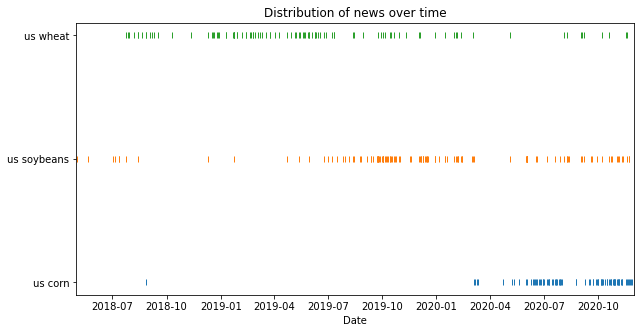

In [289]:
plt.figure(figsize=(10,5))
for i, key in enumerate(['us corn', 'us soybeans', 'us wheat']):
    x = df_grouped.get_group(key).datetime.apply(lambda x: x.date())
    plt.plot(x, np.repeat(i, len(x)), '|')
    plt.xlim((datetime.datetime(2018, 5, 1).date(), datetime.datetime(2020, 12, 1).date()))
    plt.yticks(list(range(0,3)), ['us corn', 'us soybeans', 'us wheat'])
plt.title("Distribution of news over time")
plt.xlabel("Date")

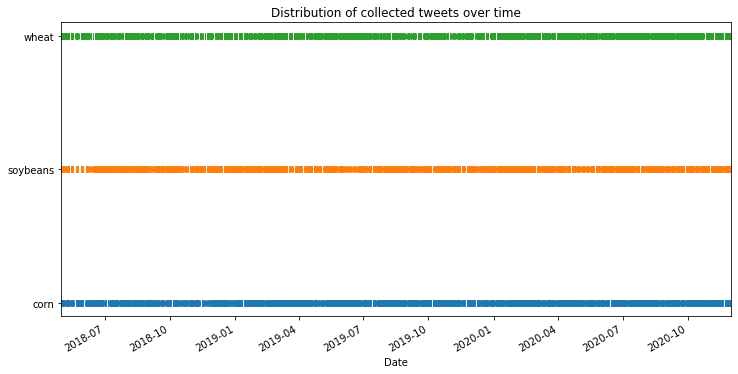

In [288]:
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(corn_tweet.index), np.repeat(1, len(corn_tweet)), '|')
plt.plot(pd.to_datetime(soybeans_tweet.index), np.repeat(2, len(soybeans_tweet)), '|')
plt.plot(pd.to_datetime(wheat_tweet.index), np.repeat(3, len(wheat_tweet)), '|')
plt.xlim((datetime.datetime(2018, 5, 1).date(), datetime.datetime(2020, 12, 1).date()))
plt.yticks(list(range(1,4)), ["corn", "soybeans", "wheat"])
plt.title("Distribution of collected tweets over time")
plt.xlabel("Date")
plt.gcf().autofmt_xdate()

Trend of grains commodities' price

Text(0.5, 1.0, "Trend of grain commodities' price")

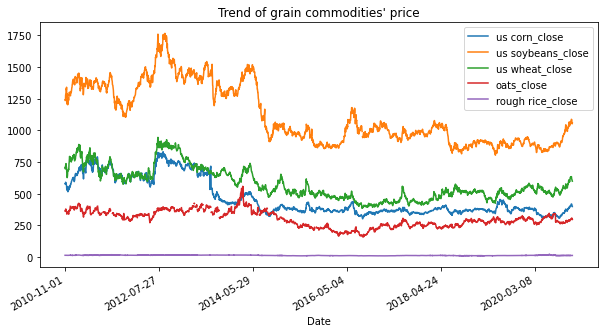

In [299]:
df_price.plot(figsize=(10,5))#.drop(["date"], axis=1).plot(figsize=(10,5))
# plt.xlim((datetime.datetime(2018, 5, 1), datetime.datetime(2020, 12, 1)))
plt.gcf().autofmt_xdate()
plt.title("Trend of grain commodities' price")